# Solver for the Fresnel Maxwell-Bloch problem
### with explicit, time forward CDF
***

## Equations:

From the equations from the paper 'Symmetry breaking, dynamical pulsations, and turbulence in the transverse intensity patterns of a laser: the role played by defects' (DOI: http://dx.doi.org/10.1016/0167-2789(92)90144-C)

$\begin{cases}
\partial_t E=-k\left([f(\rho)-i.\left[\delta+\frac{1}{2}a\left[\dfrac{\nabla^2_{\bot}}{4}+1-\rho^2\right]\right]].E-2CP\right)\\
\partial_t P=-\gamma_{\bot}[(1+i\delta)P+E.D]\\
\partial_t D=-\gamma_{\parallel}(D-\chi(\rho)-\frac{1}{2}(E^*P+EP^*))
\end{cases}$


with $E=E_x+E_y$ ;  $E_x , E_y \in \mathbb{C}$ and $P=P_x+P_y$ ; $P_x , P_y \in \mathbb{C}$

Here $f(\rho)=5+4\tanh(5(\rho-\rho_0))$, where $\rho_0$ is the cavity effective width.
$a=\dfrac{8}{T}\tan^{-1}(\frac{1}{4\eta_{1}})$ and $\eta_1=\dfrac{\pi \rho^2_0}{L\lambda}$.

$\chi(\rho)=e^{(-1.2 \frac{\rho}{\rho_0})^2}\dfrac{[1+e^{-\rho_0^2}]}{[1+e^{(\rho^2-\rho_0^2)}]}$

## Gallerkin spectral method:

Galerkin BON, the Gauss-Laguerre polynomials:

$$ A_{pm}(\rho, \varphi)=2(2\rho^2)^{m/2}(\dfrac{p!}{(p+m)!})^{1/2}e^{-\rho{^2}}L_p^m(2\rho{^2})e^{im\varphi} $$

So, let $f$ be a initial condition for some variable,  $f$ can now be written in the Gauss-Laguerre space as a linear combination, by proyecting it (such as a Fourier Series):

$$f=\sum_{pm}C_{pm}A_{pm}$$

where $$C_{pm}(t)=\langle f | A_{pm}\rangle=\iint f.A_{pm}\rho \, d\!\rho d\!\varphi  $$.

Following the paper http://sci-hub.io/10.1364/JOSAB.7.001019 ..

we use the internal product  $$\langle A_{p'm'} | A_{pm}\rangle=\iint A_{p'm'}^*.A_{pm}\rho \, d\!\rho d\!\varphi=\delta_{\rho \rho'}\delta_{\varphi \varphi'}\delta_{i i'}  $$.


so, if we consider 

$\begin{cases}
 E(\rho, \varphi, t)=\sum_{pm}\psi_{pm}(t)A_{pm}, \qquad \text{with } \qquad \psi_{pm}=\iint E(t).A_{pm}\rho \, d\!\rho d\!\varphi \\
  P(\rho, \varphi, t)=\sum_{pm}p_{pm}A_{pm}, \qquad \text{with } \qquad p_{pm}=\iint P(t).A_{pm}\rho \, d\!\rho d\!\varphi \\
  D(\rho, \varphi, t)=\sum_{pm}d_{pm}A_{pm}, \qquad \text{with } \qquad d_{pm}=\iint D(t).A_{pm}\rho \, d\!\rho d\!\varphi \\
\end{cases}$

Replacing in the differential equations, and taking the internal product with $A_{p'm'}$, we arrive at (after some redefinitions)

$\begin{cases}
\partial_t \psi_{pm}=-k'\left([f(\rho)-i.\left[\delta +a+1- \rho^2 \right].\psi_{pm}-2Ck'p_{pm}\right)\\
\partial_t p_{pm}=-\gamma_{\bot}[(1+i\delta)p_{pm}+\sum\sum \Gamma (\Sigma, \Sigma, \Sigma) \psi_{pm}d_{pm}]\\
\partial_t d_{pm}=-\gamma_{\parallel}(d_{pm}-\chi(\rho)_{pm}-\sum\sum [\Gamma (\Sigma, \Sigma, \Sigma) \psi_{pm}^*p_{pm} + c.c.])
\end{cases}$

$$\Gamma (\Sigma, \Sigma, \Sigma)=\iint A_{pm}A_{p'm'}.A_{p''m''}\rho \, d\!\rho d\!\varphi  $$


In [74]:
import numpy as np
from scipy.special import binom as binom
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
from matplotlib import cm
import matplotlib
from time import localtime
from scipy.integrate import quad, dblquad

%matplotlib inline
#from mayavi import mlab



## Parameters:

In [75]:
'''parameters for normalization'''
gperp=1   #10**8. #gamma perpendicular, loss rate
scale=1*(10.**6)/gperp #scale to micro seconds
wscale=1000*gperp/(10.**6)#scale frequency to khz

'''parameters for the equation'''
a=.1
k=1.# 0.9*10.**7/gperp loos rate
d=0.00018      #0.01 #detuning
g=0.01      #2.5*10.**4/gperp #*((2*pi)**2) #sigma parallel, loss rate
m=0.0    #modulation amplitud [0,1]
wf=4.7434    #0.001*2*pi #modulation frequency
rho=.75
D0=0.  #(es el pump)

In [76]:
'''perdidas'''
rho_0=1.
def loss(x,y):
    loss=5.+4.*np.tanh(5.*(x-rho_0))
    return loss

'''bombeo'''
def pump(x,y):    
    pump=.5-np.tanh(5*(x-rho_0))/2.
    return pump


## Basis

In [77]:
'''defino Lpm'''
def Ln(p,m,xj):
    Ln=0.
    for i in range(int(p)+1):#el p+1 es por la indexacion
        Ln=Ln+((-1)**i)*binom(p+m,p-i)*(xj**i)/np.math.factorial(i)
    return Ln

'''Defino Apm'''
def A(rn,phin,p,m,i):
    A=0.
    if m==0:
        A=2*np.exp(-rn**2)*Ln(p,0,2*rn**2)*(1/np.sqrt(2*pi))
    elif i==0:
        A=2*((2*rn**2)**(m/2))*np.sqrt(np.math.factorial(p)*(1./np.math.factorial(p+m)))*np.exp(-rn**2)*Ln(p,m,2*(rn**2))*(1/np.sqrt(pi))*np.sin(m*phin)
    elif i==1:
        A=2*((2*rn**2)**(m/2))*np.sqrt(np.math.factorial(p)*(1./np.math.factorial(p+m)))*np.exp(-rn**2)*Ln(p,m,2*(rn**2))*(1/np.sqrt(pi))*np.cos(m*phin)
    
    return A

In [78]:
def F(r,phi,p,m,i):
    F=np.zeros((len(phi), len(r)))
    for j, rn in enumerate(r):
        for k, phin in enumerate(phi):
            F[k,j]=A(rn,phin,p,m,i)
    return F

In [79]:
def plotter(f,r,phi):
    plotter=np.zeros((len(phi), len(r)))
    for j, rn in enumerate(r):
        for k, phin in enumerate(phi):
            plotter[k,j]=f(rn,phin)
    return plotter

## Colocacion:

In [80]:
pi=np.pi
r=np.linspace(0,8,250)
phi=np.linspace(0,2*pi,90)

## Cuadraturas

In [81]:
def proy(func,p,m,i):
    return dblquad(lambda rn, phin: func(rn,phin)*A(rn,phin,p,m,i)*rn, 0, 2*pi, lambda phin: 0, lambda phin: 15)  

In [82]:
#def descomp(func,p_max):
 #   for p in range(p_max):
    #      for m in range(p):
    #         for i in range(2):
    #            coef(p,m,i)=proy(func,p,m,i)
                
    #return coef(p,m,i)

def transf(func,r,phi,p_max):
    Z=np.zeros((len(phi), len(r)))
    for p in range(p_max+1):
        for m in range(p+1):
            if m==0:
                i=0
                Z=Z+proy(func,p,m,i)[0]*F(r,phi,p,m,i)
            else:
                for i in range(2):
                    Z=Z+proy(func,p,m,i)[0]*F(r,phi,p,m,i) 
                    
    return Z

In [83]:
'''plots'''
save=False #set True if i want to save files automatically
R, P = np.meshgrid(r, phi)
X, Y = R*np.cos(P), R*np.sin(P)


In [84]:
test=transf(pump,r,phi,8)

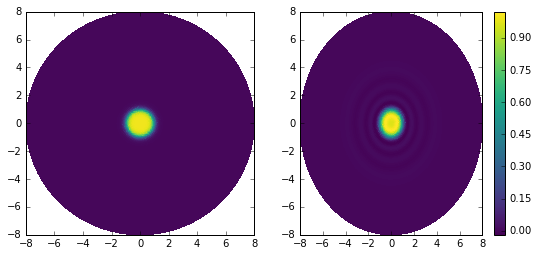

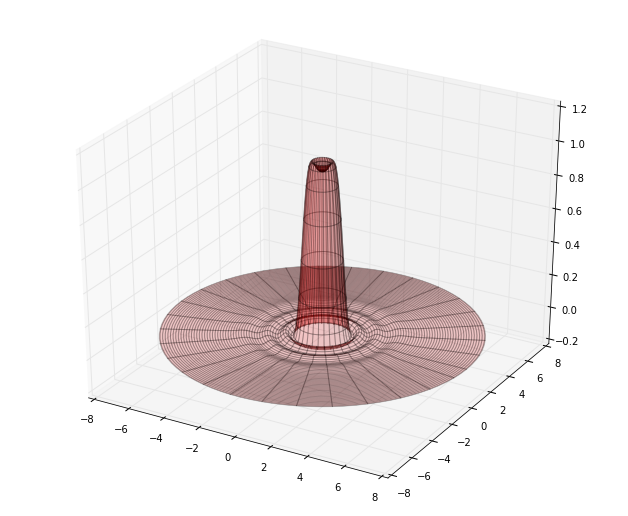

In [92]:
fig, (ax0, ax1) = pyplot.subplots(ncols=2, figsize=(9, 4))
cs0=ax0.pcolormesh(X, Y, plotter(pump,r,phi),cmap=pyplot.get_cmap('viridis'),vmin=np.min(test), vmax=np.max(test))
pyplot.colorbar(cs0)
cs1=ax1.pcolormesh(X, Y, test,cmap=pyplot.get_cmap('viridis'),vmin=np.min(test), vmax=np.max(test))



fig = pyplot.figure(figsize=(11,9), dpi=100)
ax = pyplot.subplot(111, projection='3d')
ax.plot_surface(X, Y, test,  color="red", rstride=3, cstride=4, alpha=0.2)
#ax.plot_surface(X, Y, plotter(pump,r,phi), rstride=3, cstride=4, alpha=0.7)



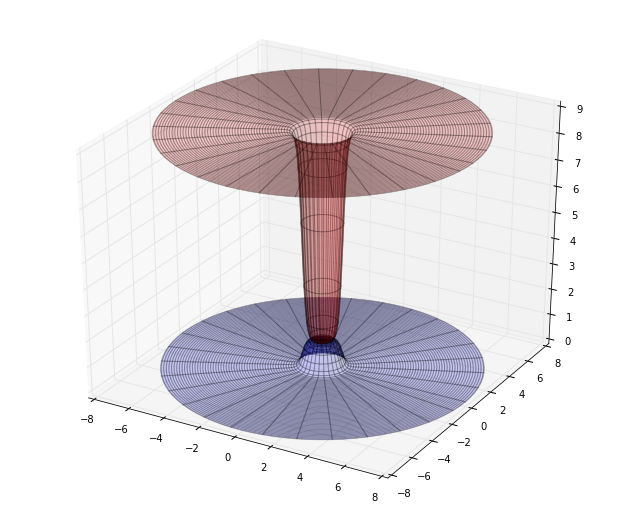

In [86]:
fig = pyplot.figure(figsize=(11,9), dpi=100)
ax = pyplot.subplot(111, projection='3d')
ax.plot_surface(X, Y, plotter(loss,r,phi), color="red",  rstride=3, cstride=4, alpha=0.2)
ax.plot_surface(X, Y, plotter(pump,r,phi), rstride=3, cstride=4, alpha=0.2)

## Initial conditions

In [87]:
'''Condiciones iniciales a partir de funciones.'''
def init_from_functions():
    ''' campo electrico en x'''
    def dfxr_init(x,y):
        dfxr_init=A(x,y,0,0,0)
        return dfxr_init
    def dfxi_init(x,y):
        dfxi_init=A(x,y,0,0,0)
        return dfxi_init
    '''campo electrico en y'''
    def dfyr_init(x,y):
        dfyr_init=np.exp(-x)
        return dfyr_init
    def dfyi_init(x,y):
        dfyi_init=np.exp(-x)
        return dfyi_init
    '''polarizacion en x'''
    def drxr_init(x,y):
        drxr_init=np.exp(-x)
        return drxr_init
    def drxi_init(x,y):
        drxi_init=np.exp(-x)
        return drxi_init
    '''polarizacion en y'''
    def dryr_init(x,y):
        dryr_init=np.exp(-x)
        return dryr_init
    def dryi_init(x,y):
        dryi_init=np.exp(-x)
        return dryi_init
    '''poblacion'''
    def ddelta_init(x,y):
        ddelta_init=np.exp(-x)
        return ddelta_init


In [88]:
init_from_functions()

In [89]:
def init_from_coeffs(p_max):
    inits=['fxr','fxi','fyr','fyi','rxr','rxi','ryr','ryi','delta']
    for a,b in enumerate(inits):
        with open(b+'_init.txt','w') as file:
            with open(b+'.txt','w') as file2:
                print>>file, '%d_%d_%d-%d.%d.%d  ' % localtime()[0:6], b
                print>>file2, '%d_%d_%d-%d.%d.%d  ' % localtime()[0:6], b
                for p in range(p_max+1):
                    for m in range(p+1):
                        if m==0:
                            i=0
                            randi=np.random.rand()
                            print>>file, 'C,%i,%i,%i,=,%.20f, ' % (p, m, i, randi)
                            print>>file2, 'C,%i,%i,%i,=,%.20f, ' % (p, m, i, randi)

                        else:
                            for i in range(2):
                                randi=np.random.rand()
                                print>>file, 'C,%i,%i,%i,=,%.20f, ' % (p, m, i, randi)     
                                print>>file2, 'C,%i,%i,%i,=,%.20f, ' % (p, m, i, randi)     


print 'done'
            

done


In [90]:
def read_inits():
    inits=['fxr','fxi','fyr','fyi','rxr','rxi','ryr','ryi','delta']
    funits=np.zeros(len(inits))
    for a,b in enumerate(inits):
        print a
        funits[a]=np.zeros((len(phi), len(r)))
        print funits
        with open(b+'.txt','r') as file:
            for line in file:
                if line[0]=='C':
                    print funits
                    cof = line.split(",")
            #print int(cof[1]),int(cof[2]),int(cof[3]),np.float(cof[5])
                    funits[a]=funits[a]+F(r,phi,int(cof[1]),int(cof[2]),int(cof[3]))*np.float(cof[5])       
    return funits
                
        

In [91]:
funits=read_inits()

fig = pyplot.figure(figsize=(7,5), dpi=100)
pyplot.pcolormesh(X, Y, funits[0],cmap=pyplot.get_cmap('viridis'), vmax=np.abs(Z).max())
pyplot.colorbar()
ax.contour(X, Y, Z, cmap=pyplot.get_cmap('viridis'), vmax=np.abs(Z).max())

fig = pyplot.figure(figsize=(11,9), dpi=100)
ax = pyplot.subplot(111, projection='3d')
ax.contourf(X, Y, funits[0], 9, zdir='z', offset=np.min(Z), cmap=pyplot.get_cmap('viridis'), vmax=np.abs(Z).max(), vmin=-np.abs(Z).max())
ax.contourf(X, Y, funits[0], zdir='x', offset=-np.max(Y), cmap=pyplot.get_cmap('viridis'))
ax.plot_surface(X, Y, funits[0], rstride=3, cstride=4, alpha=0.25  )


0


ValueError: setting an array element with a sequence.

## integration:

In [ ]:
import numpy as np
from scipy.integrate import odeint

intime=30. 
time = np.arange(0., intime, 1)

def integ(yinit,time,k,d,g,D0):
    #le falta la parte no lineal las perdidas, el bombeo y a

    C=1.
    nl=1.
    apm=1
    
    def mb(y, t):
        
        #  for c in yinit:

        """ y[0],y[1] campo electrico en x. y[2],y[3] campo electrico en y, y[4],y[5]  polarizacion en x, y[6],y[7]  polarizacion en y, y[8] poblacion. """
        ''' campo electrico en x'''
        dfxr=-k*y[0]-(apm-d)*y[1]-2*C*k*y[4]
        dfxi=-k*y[1]+(apm-d)*y[0]-2*C*k*y[5]
        '''campo electrico en y'''
        dfyr=-k*y[2]-(apm-d)*y[3]-2*C*k*y[6]
        dfyi=-k*y[3]+(apm-d)*y[2]-2*C*k*y[7]
        '''polarizacion en x'''
        drxr=-(1*y[4]-d*y[5])+y[0]*y[8]*nl
        drxi=-(1*y[5]+d*y[4])+y[1]*y[8]*nl
        '''polarizacion en y'''
        dryr=-(1*y[6]-d*y[7])+y[2]*y[8]
        dryi=-(1*y[7]+d*y[6])+y[3]*y[8]
        '''poblacion'''
        ddelta=-g*(y[8]-D0+nl*(y[0]*y[4]+y[1]*y[5]+y[2]*y[6]+y[3]*y[7]))
        return [dfxr,dfxi,dfyr,dfyi,drxr,drxi,dryr,dryi,ddelta]

    y = odeint(mb, yinit, time)
    return y, time


inits=['fxr','fxi','fyr','fyi','rxr','rxi','ryr','ryi','delta']
funits=np.zeros(len(inits))
for a,b in enumerate(inits):
    with open(b+'.txt','r+') as file:
        for line in file:
            if line[0]=='C':
                print funits
                cof = line.split(",")
                funits[a]=funits[a]+F(r,phi,int(cof[1]),int(cof[2]),int(cof[3]))*np.float(cof[5])       
return funits


y,time=integ(yinit,time,k,d,g,D0)


'''ejemplo de grafico de intensidad'''

R, P = np.meshgrid(r, phi)
X, Y = R*np.cos(P), R*np.sin(P)

'''function:'''
Z=np.sqrt(y[-1][0]*F(r,phi,0,0,0)**2+y[-1][1]*F(r,phi,0,0,0)**2+y[-1][2]*F(r,phi,0,0,0)**2+y[-1][3]*F(r,phi,0,0,0)**2)

fig = pyplot.figure(figsize=(9,8), dpi=100)
pyplot.pcolormesh(X, Y, Z,cmap=pyplot.get_cmap('viridis'), vmax=np.abs(Z).max())
pyplot.colorbar()
ax.contour(X, Y, Z, cmap=pyplot.get_cmap('viridis'), vmax=np.abs(Z).max())

#fig = pyplot.figure(figsize=(11,9), dpi=100)
#ax = pyplot.subplot(111, projection='3d')
#ax.contourf(X, Y, Z, 9, zdir='z', offset=np.min(Z), cmap=pyplot.get_cmap('viridis'))
#ax.contourf(X, Y, Z, zdir='x', offset=-np.max(Y), cmap=pyplot.get_cmap('viridis'))
#ax.plot_surface(X, Y, Z, rstride=3, cstride=4, alpha=0.1  )

fig2 = pyplot.figure(figsize=(9,8), dpi=100)
pyplot.contourf(X, Y, Z,13, interpolation='bilinear', cmap=pyplot.get_cmap('viridis'))
pyplot.colorbar()


#Function for initializing simulations after the transition
def  initial(init, time, y):
    intime=500.*17*10**(-6)*gperp #integration time FOR TRANDITORY
    if init=='new':
        '''User defined initial condition'''
        timeinit = np.arange(0., intime, 1.)
        dfxinit=[1., 1.] 
        dfyinit=[1.,  -1.9]  
        drxinit=[1.,   1.]
        dryinit=[1.,  -1.9] 
        ddeltainit=[6.65973518e+03]
        yinit=np.array(dfxinit+dfyinit+drxinit+dryinit+ddeltainit)
    if init=='l':
        '''initial condition from last simulation'''
        timeinit = np.arange(time[-1] ,intime*5/17+time[-1] , 1.)
        yinit=y[-1]
    return yinit, timeinit


In [ ]:
#Tchebychef colocation:
rmax=4.
N=30
M=20
k=4#interpolation degree
j=range(N)
rj=(rmax/2.)*np.cos((2*j+pi)/2*k)+rmax/2
l=range(M)
rj=(2*pi/2.)*np.cos((2*j+pi)/2*k)+2*pi/2


## Boundary conditions:

In [ ]:
from numba import autojit
%matplotlib inline

## Integrating function
***

In [ ]:
'''Condiciones iniciales con partes random'''
    
def randal(x,y):
    randal=np.random.normal()*pump(x,y)
    return randal

In [93]:
'''Descomponer funcion y escribir coefs en archivo.'''
p_max=10
with open('coeff_galerkin.txt','w') as file:
    func= dfyr_init   
    print>>file, '%d_%d_%d-%d.%d.%d gslrtkin coefficients \n' % localtime()[0:6]
    for p in range(p_max+1):
        for m in range(p+1):
            if m==0:
                i=0
                print>>file, 'C,%i,%i,%i,=,%.20f, ' % (p, m, i, proy(func,p,m,i)[0])
            else:
                for i in range(2):
                    print>>file, 'C,%i,%i,%i,=,%.20f, ' % (p, m, i, proy(func,p,m,i)[0])     
                    
print 'done'

NameError: name 'dfyr_init' is not defined

ValueError: zero-size array to reduction operation minimum which has no identity

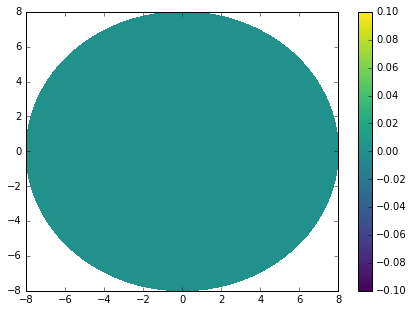

In [94]:
Z=np.zeros((len(phi), len(r)))
galfile=open('coeff_galerkin.txt','r')
for line in galfile:
    if line[0]=='C':
        cof = line.split(",")
        #print int(cof[1]),int(cof[2]),int(cof[3]),np.float(cof[5])
        Z=Z+F(r,phi,int(cof[1]),int(cof[2]),int(cof[3]))*np.float(cof[5])       
galfile.close()


fig = pyplot.figure(figsize=(7,5), dpi=100)
pyplot.pcolormesh(X, Y, Z,cmap=pyplot.get_cmap('viridis'), vmax=np.abs(Z).max())
pyplot.colorbar()
ax.contour(X, Y, Z, cmap=pyplot.get_cmap('viridis'), vmax=np.abs(Z).max())

fig = pyplot.figure(figsize=(11,9), dpi=100)
ax = pyplot.subplot(111, projection='3d')
ax.contourf(X, Y, Z, 9, zdir='z', offset=np.min(Z), cmap=pyplot.get_cmap('viridis'), vmax=np.abs(Z).max(), vmin=-np.abs(Z).max())
ax.contourf(X, Y, Z, zdir='x', offset=-np.max(Y), cmap=pyplot.get_cmap('viridis'))
ax.plot_surface(X, Y, Z, rstride=3, cstride=4, alpha=0.25  )


In [ ]:
'''ejemplo de grafico, para ve que funcionan las Apm'''

R, P = np.meshgrid(r, phi)
X, Y = R*np.cos(P), R*np.sin(P)

'''function:'''
Z=0.5*F(r,phi,13,3,2)+F(r,phi,13,3,1)+0.1*F(r,phi,13,0,1)

fig = pyplot.figure(figsize=(9,8), dpi=100)
ax = pyplot.subplot(111)
pyplot.pcolormesh(X, Y, Z,cmap=pyplot.get_cmap('viridis'), vmax=np.abs(Z).max(), vmin=-np.abs(Z).max())
pyplot.colorbar()
ax.contour(X, Y, Z, cmap=pyplot.get_cmap('viridis'), vmax=np.abs(Z).max(), vmin=-np.abs(Z).max())

fig = pyplot.figure(figsize=(11,9), dpi=100)
ax = pyplot.subplot(111, projection='3d')
ax.contourf(X, Y, Z, 9, zdir='z', offset=np.min(Z), cmap=pyplot.get_cmap('viridis'), vmax=np.abs(Z).max(), vmin=-np.abs(Z).max())
ax.contourf(X, Y, Z, zdir='x', offset=-np.max(Y), cmap=pyplot.get_cmap('viridis'))
ax.plot_surface(X, Y, Z, rstride=3, cstride=4, alpha=0.25  )

if save==True: 
    fname='%d_%d_%d-%d.%d.%d-testmaxwell.png' % localtime()[0:6]
    fig.savefig(fname, dpi = 250)# when saving, specify the DPI



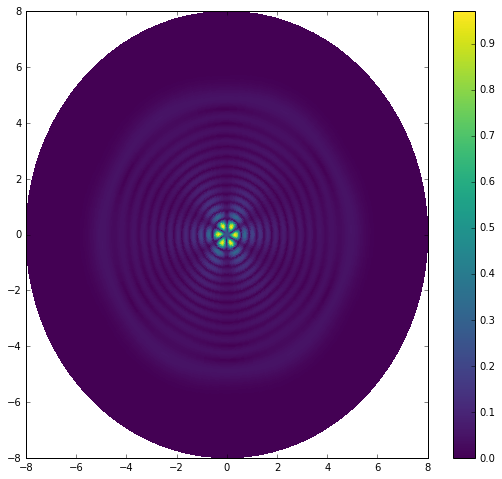

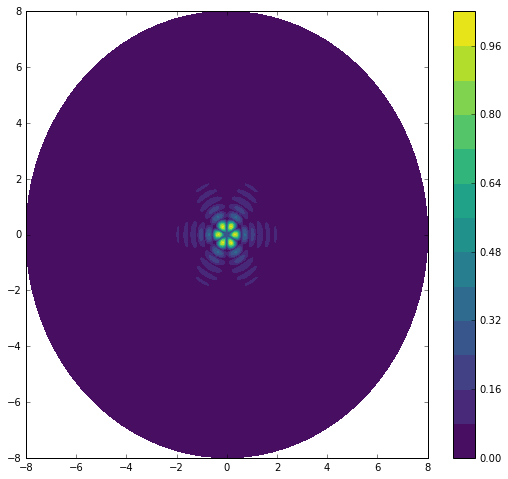

In [95]:
'''ejemplo de grafico de intensidad'''

R, P = np.meshgrid(r, phi)
X, Y = R*np.cos(P), R*np.sin(P)

'''function:'''
Z=np.sqrt(0.5*F(r,phi,13,3,2)**2+F(r,phi,13,3,1)**2+0.1*F(r,phi,13,0,1)**2)

fig = pyplot.figure(figsize=(9,8), dpi=100)
pyplot.pcolormesh(X, Y, Z,cmap=pyplot.get_cmap('viridis'), vmax=np.abs(Z).max())
pyplot.colorbar()
ax.contour(X, Y, Z, cmap=pyplot.get_cmap('viridis'), vmax=np.abs(Z).max())

#fig = pyplot.figure(figsize=(11,9), dpi=100)
#ax = pyplot.subplot(111, projection='3d')
#ax.contourf(X, Y, Z, 9, zdir='z', offset=np.min(Z), cmap=pyplot.get_cmap('viridis'))
#ax.contourf(X, Y, Z, zdir='x', offset=-np.max(Y), cmap=pyplot.get_cmap('viridis'))
#ax.plot_surface(X, Y, Z, rstride=3, cstride=4, alpha=0.1  )

fig2 = pyplot.figure(figsize=(9,8), dpi=100)
pyplot.contourf(X, Y, Z,13, interpolation='bilinear', cmap=pyplot.get_cmap('viridis'))
pyplot.colorbar()


NameError: name 'dfyr_init' is not defined

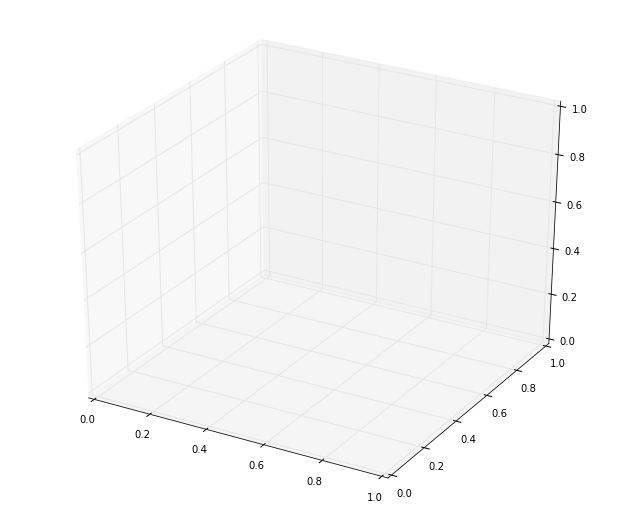

In [96]:
fig = pyplot.figure(figsize=(11,9))
ax = pyplot.subplot(111, projection='3d')
ax.plot_wireframe(X, Y, plotter(dfyr_init,r,phi), color="red",  rstride=3, cstride=4, alpha=0.25   )
#ax.plot_wireframe(X, Y, test2, color="blue",  rstride=3, cstride=4, alpha=0.25   )

fig = pyplot.figure(figsize=(9,7))
pyplot.pcolormesh(X, Y, plotter(dfyr_init,r,phi),cmap=pyplot.get_cmap('viridis'))
pyplot.colorbar()

#fig = pyplot.figure()
#pyplot.pcolormesh(X, Y, test2,cmap=pyplot.get_cmap('viridis'))
#pyplot.colorbar()
